# Procrustres analysis of rarefied and non-rarefied abundances 

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

To quantify differences in community composition among samples (beta diversity) and identify variability patterns, we computed Aitchison distances which acknowledge the compositional nature of the microbial taxonomic profiles \[<cite data-cite="2542765/SHS9BWJH"></cite>,<cite data-cite="2542765/C3H7KZUL"></cite>\]. Aitchison distances correspond to Euclidean distances among taxonomic profiles (i.e taxon abundances) that were centred log-ratio (CLR) transformed. The CLR transformation takes compositional vectors(i.e relative abundances) from a constrained space (i.e the unit simplex) to an unconstrained space of logratio vectors (logarithm of the ratio between the abundance of a taxon in a sample and the geometric mean of all taxon abundances in the same sample). The CLR transformation is scale-invariant, meaning that the resulting logratio vectors do not depend on the magnitude of the total sum of the compositional vector <cite data-cite="2542765/H7TDTQR9"></cite>. This implies that rarefying the taxonomic profiles to a constant value across samples will not have an effect on the resulting transformed vector and therefore on the values of the pairwise Aitchison distances. We indeed found a high correlation between ordinations based on Aitchison distances of rarefied and non-rarefied abundances (Procrustes R<sup>2</sup>=0.98, p-value = 0.001). We therefore computed Aitchison distances on non-rarefied taxonomic profiles. To circumvent the limitation of undefined values when computing the logarithm of zero values, zero abundances were replaced following Martin-Fernández et al.'s Bayesian-multiplicative replacement strategy <cite data-cite="2542765/DTSGMSZ3"></cite>; implemented in _cmultRepl_ of the R package _zCompositions_.

**References**

<div class="cite2c-biblio"></div>

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-16


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(ggplot2)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(RColorBrewer)
library(grid)
library(gridExtra)
library(zCompositions)
library(factoextra)
library(vegan)
library(ggpubr)
options("width"=200)

## 1. Input files

### 1.1 16S-AS taxonomic profiles

**Taxonomy table**

In [5]:
%%R
# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

cat("\nNr of ASVs: ")
cat(dim(asv16s_taxonomy_table)[1])

cat("\nNr of taxonomic levels: ")
cat(dim(asv16s_taxonomy_table)[2])

# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA


[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia

Nr of ASVs: 28284
Nr of taxonomic levels: 7

**Non-rarefied abundance table**

In [6]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)

print(asv16s_qiime2_feature_table[0:3,0:3])

# Create phyloseq object
# ----------------------
# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)


# Remove samples with less than 12000 total reads
asv16s_feature_table_ps <- prune_samples(sample_sums(asv16s_feature_table_ps) >=12000, 
                                         asv16s_feature_table_ps)

# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)

cat("\nContent of Phyloseq object: \n")
print(asv16s_feature_table_ps)

                                 A00030 A00034 A00036
0000134bb4f9a56941dd1d0206a600d8      0      0      0
00032a9354651fef5c866ec3f9cdca0d      0      0      0
000374910b98b14cc5724af75f294b87      0      0      0
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]

Content of Phyloseq object: 
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27668 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 27668 taxa by 7 taxonomic ranks ]


**Rarefied abundance table**

In [7]:
%%R
asv16s_qiime2_feature_table_12K_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/rarefaction/feature_table_depth12k.tsv"
asv16s_qiime2_feature_table_12K<- read.table(asv16s_qiime2_feature_table_12K_file, header=TRUE, sep='\t', 
                                             stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                             comment.char="", skip=1)

print(asv16s_qiime2_feature_table_12K[0:3,0:3])

# Create phyloseq object
# ----------------------
# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_12k_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table_12K, 
                                                  taxa_are_rows=TRUE), 
                                        tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_12k_ps)


# remove ASV with abundance zero
asv16s_feature_table_12k_ps = filter_taxa(asv16s_feature_table_12k_ps, function(x){sum(x) > 0}, TRUE)

cat("\nContent of Phyloseq object: \n")
print(asv16s_feature_table_12k_ps)

                                 A00030 A00034 A00036
00032a9354651fef5c866ec3f9cdca0d      0      0      0
000374910b98b14cc5724af75f294b87      0      0      0
0003d22e4413dac1cd70b02db4b1911a      0      0      0
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21368 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 21368 taxa by 7 taxonomic ranks ]

Content of Phyloseq object: 
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21368 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 21368 taxa by 7 taxonomic ranks ]


## 2. Evaluate effect of sequencing depth on compositional data analysis (CoDA)

### 2.1 Ordinations based on Centred log-ratio (CLR) transformed abundances of Amplicon Sequence Variants (ASVs)

**CLR transformation of non-rarefied ASV abundance table**

In [8]:
%%R
# CLR transformation
# -------------------
# Filter rare ASVs
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*length(sample_names(asv16s_feature_table_ps))/100)
is_above_prev_cutoff <- as.vector(rowSums(otu_table(asv16s_feature_table_ps)>0) >= prevalence_cutoff)
asv16s_feature_table_clr <- otu_table(asv16s_feature_table_ps)[is_above_prev_cutoff,]
print(dim(asv16s_feature_table_clr))

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_feature_table_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_feature_table_clr)[sample_has_zero_totals])
    asv16s_feature_table_clr <- asv16s_feature_table_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(ASV-by-samples) of filtered table: ",
    dim(asv16s_feature_table_clr),'\n\n')

# Replace Zeroes (imputation of zeroes) by Bayesian-multiplicative replacement
# returns a sample-by-features table (samples as rows)
cat("\nImputation of zeroes:\n")
asv16s_feature_table_clr <- cmultRepl(t(asv16s_feature_table_clr), 
                                      label=0, method="CZM", output="p-counts")

# Finally, apply CLR-transformation, transposed to return samples as rows
asv16s_feature_table_clr <- t(apply(asv16s_feature_table_clr, 1, 
                                            function(x){log(x) - mean(log(x))}))
cat("\nDimensions(samples-by-ASVs) of filtered table: ",
    dim(asv16s_feature_table_clr),'\n')

[1] 580 307

Dimensions(ASV-by-samples) of filtered table:  580 307 


Imputation of zeroes:
No. corrected values:  2873 

Dimensions(samples-by-ASVs) of filtered table:  307 580 


**CLR transformation of rarefied ASV abundance table**

In [9]:
%%R
# CLR transformation
# -------------------
# Filter rare ASVs
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*length(sample_names(asv16s_feature_table_12k_ps))/100)
is_above_prev_cutoff <- as.vector(rowSums(otu_table(asv16s_feature_table_12k_ps)>0) >= prevalence_cutoff)
asv16s_feature_table_12k_clr <- otu_table(asv16s_feature_table_12k_ps)[is_above_prev_cutoff,]
print(dim(asv16s_feature_table_12k_clr))

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_feature_table_12k_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_feature_table_12k_clr)[sample_has_zero_totals])
    asv16s_feature_table_12k_clr <- asv16s_feature_table_12k_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(ASV-by-samples) of filtered table: ",
    dim(asv16s_feature_table_12k_clr),'\n\n')

# Replace Zeroes (imputation of zeroes) by Bayesian-multiplicative replacement
# returns a sample-by-features table (samples as rows)
cat("\nImputation of zeroes:\n")
asv16s_feature_table_12k_clr <- cmultRepl(t(asv16s_feature_table_12k_clr), 
                                          label=0, method="CZM", output="p-counts")

# Finally, apply CLR-transformation, transposed to return samples as rows
asv16s_feature_table_12k_clr <- t(apply(asv16s_feature_table_12k_clr, 1, 
                                            function(x){log(x) - mean(log(x))}))
cat("\nDimensions(samples-by-ASVs) of filtered table: ",
    dim(asv16s_feature_table_12k_clr),'\n')

[1] 552 307

Dimensions(ASV-by-samples) of filtered table:  552 307 


Imputation of zeroes:
No. corrected values:  3220 

Dimensions(samples-by-ASVs) of filtered table:  307 552 


**How comparable are PCA ordinations of CLR-transoformed non-rarefied and rarefied ASV tables?**

In [10]:
%%R
# Principal Component Analysis (PCA)
# with non-rarefied CLR transformed feature table
asv16s_feature_table_clr_pca <- prcomp(asv16s_feature_table_clr, center=TRUE, scale=FALSE)
# with rarefied CLR trasformed feature table
asv16s_feature_table_12k_clr_pca <- prcomp(asv16s_feature_table_12k_clr[rownames(asv16s_feature_table_clr),], 
                                           center=TRUE, scale=FALSE)

clr_pca.vs.clr_12k_pca.procrustes <- procrustes(X=asv16s_feature_table_clr_pca, 
                                                Y=asv16s_feature_table_12k_clr_pca, 
                                                symmetric=TRUE)
print(clr_pca.vs.clr_12k_pca.procrustes)

clr_pca.vs.clr_12k_pca.protest <- protest(X=asv16s_feature_table_clr_pca, 
                                          Y=asv16s_feature_table_12k_clr_pca, 
                                          scores="sites", permutations = 999)
print(clr_pca.vs.clr_12k_pca.protest)


Call:
procrustes(X = asv16s_feature_table_clr_pca, Y = asv16s_feature_table_12k_clr_pca,      symmetric = TRUE) 

Procrustes sum of squares:
0.02465 


Call:
protest(X = asv16s_feature_table_clr_pca, Y = asv16s_feature_table_12k_clr_pca,      scores = "sites", permutations = 999) 

Procrustes Sum of Squares (m12 squared):        0.02465 
Correlation in a symmetric Procrustes rotation: 0.9876 
Significance:  0.001 

Permutation: free
Number of permutations: 999



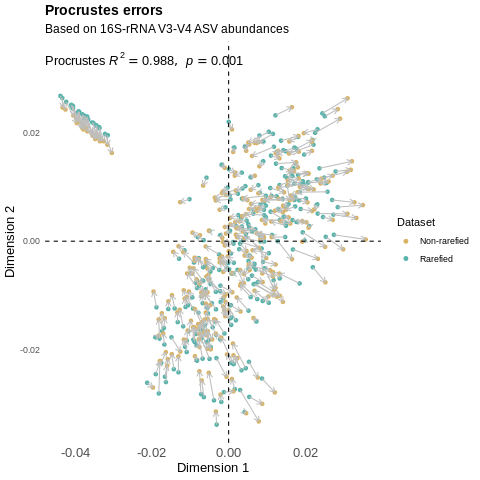

In [11]:
%%R
# Procrustes plot
procrustes_df_to_plot <- data.frame(Y1=clr_pca.vs.clr_12k_pca.procrustes$Yrot[,1],
                                    Y2=clr_pca.vs.clr_12k_pca.procrustes$Yrot[,2],
                                    X1=clr_pca.vs.clr_12k_pca.procrustes$X[,1],
                                    X2=clr_pca.vs.clr_12k_pca.procrustes$X[,2]
                                    )

procrustes_colors <- c("Non-rarefied"="#d8b365", "Rarefied"="#5ab4ac")
procrustes_annotations <- paste0("list(Procrustes~italic(R^2)== ", round(clr_pca.vs.clr_12k_pca.protest$t0,3),
                                 ",~italic(p)== ", round(clr_pca.vs.clr_12k_pca.protest$signif,3), ")")

asv16s_procrustes_plot <- ggplot(data=procrustes_df_to_plot) + 
                            geom_point(aes(x=Y1, y=Y2, color="Rarefied")) +
                            geom_point(aes(x=X1, y=X2, color="Non-rarefied")) +
                            geom_segment(aes(x=Y1,y=Y2,xend=X1,yend=X2),
                                         arrow=arrow(length=unit(0.2,"cm")), 
                                         colour="gray") + 
                            geom_hline(yintercept=0, linetype="dashed") + 
                            geom_vline(xintercept=0, linetype="dashed") + 
                            scale_color_manual(values=procrustes_colors) + 
                            annotate("text", label=procrustes_annotations, 
                                     x=-Inf, y=max(procrustes_df_to_plot$Y1+0.005), 
                                     hjust=0, parse=TRUE, size=4.5) +
                            labs(x="Dimension 1", y="Dimension 2", title="Procrustes errors", 
                                 subtitle="Based on 16S-rRNA V3-V4 ASV abundances", color="Dataset") +
                            theme_minimal() + 
                            theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                  plot.subtitle = element_text(hjust=0,size=12),
                                  axis.text.x=element_text(size=13), 
                                  axis.title=element_text(size=13), 
                                  panel.grid.major = element_blank(), 
                                  panel.grid.minor = element_blank())
asv16s_procrustes_plot

### 2.2 Ordinations based on Centred log-ratio (CLR) transformed species-level abundances

**CLR transformation of non-rarefied species-level abundance table**

In [12]:
%%R
# Aggregate abundances to the species level
asv16s_bacteria_spp_table_clr <- otu_table(tax_glom(subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria"), 
                                                "Species", NArm=FALSE))
print(dim(asv16s_bacteria_spp_table_clr))

[1] 685 307


In [13]:
%%R
# CLR transformation
# -------------------
# Filter rare Spp.
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*length(sample_names(asv16s_feature_table_ps))/100)
is_above_prev_cutoff <- as.vector(rowSums(asv16s_bacteria_spp_table_clr>0) >= prevalence_cutoff)
asv16s_bacteria_spp_table_clr <- asv16s_bacteria_spp_table_clr[is_above_prev_cutoff,]
print(dim(asv16s_bacteria_spp_table_clr))

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_spp_table_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_spp_table_clr)[sample_has_zero_totals])
    asv16s_bacteria_spp_table_clr <- asv16s_bacteria_spp_table_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(ASV-by-samples) of filtered table: ",
    dim(asv16s_bacteria_spp_table_clr),'\n\n')

# Replace Zeroes (imputation of zeroes) by Bayesian-multiplicative replacement
# returns a sample-by-features table (samples as rows)
cat("\nImputation of zeroes:\n")
asv16s_bacteria_spp_table_clr <- cmultRepl(t(asv16s_bacteria_spp_table_clr),
                                           label=0, method="CZM", output="p-counts")

# Finally, apply CLR-transformation, transposed to return samples as rows
asv16s_bacteria_spp_table_clr <- t(apply(asv16s_bacteria_spp_table_clr, 1, 
                                         function(x){log(x) - mean(log(x))}))
cat("\nDimensions(samples-by-Spp) of filtered table: ",
    dim(asv16s_bacteria_spp_table_clr),'\n')

[1] 189 307

Dimensions(ASV-by-samples) of filtered table:  189 307 


Imputation of zeroes:
No. corrected values:  1832 

Dimensions(samples-by-Spp) of filtered table:  307 189 


**CLR transformation of Rarefied species-level abundance table**

In [14]:
%%R
# Aggregate abundances to the species level
asv16s_bacteria_spp_table_12k_clr <- otu_table(tax_glom(subset_taxa(asv16s_feature_table_12k_ps, 
                                                                    Kingdom=="k__Bacteria"), 
                                                        "Species", NArm=FALSE))
print(dim(asv16s_bacteria_spp_table_12k_clr))

[1] 613 307


In [15]:
%%R
# CLR transformation
# -------------------
# Filter rare Spp.
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*length(sample_names(asv16s_feature_table_12k_ps))/100)
is_above_prev_cutoff <- as.vector(rowSums(asv16s_bacteria_spp_table_12k_clr>0) >= prevalence_cutoff)
asv16s_bacteria_spp_table_12k_clr <- asv16s_bacteria_spp_table_12k_clr[is_above_prev_cutoff,]
print(dim(asv16s_bacteria_spp_table_12k_clr))

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_spp_table_12k_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_spp_table_12k_clr)[sample_has_zero_totals])
    asv16s_bacteria_spp_table_12k_clr <- asv16s_bacteria_spp_table_12k_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(ASV-by-samples) of filtered table: ",
    dim(asv16s_bacteria_spp_table_12k_clr),'\n\n')

# Replace Zeroes (imputation of zeroes) by Bayesian-multiplicative replacement
# returns a sample-by-features table (samples as rows)
cat("\nImputation of zeroes:\n")
asv16s_bacteria_spp_table_12k_clr <- cmultRepl(t(asv16s_bacteria_spp_table_12k_clr),
                                               label=0, method="CZM", output="p-counts")

# Finally, apply CLR-transformation, transposed to return samples as rows
asv16s_bacteria_spp_table_12k_clr <- t(apply(asv16s_bacteria_spp_table_12k_clr, 1, 
                                             function(x){log(x) - mean(log(x))}))
cat("\nDimensions(samples-by-Spp) of filtered table: ",
    dim(asv16s_bacteria_spp_table_12k_clr),'\n')

[1] 174 307

Dimensions(ASV-by-samples) of filtered table:  174 307 


Imputation of zeroes:

Dimensions(samples-by-Spp) of filtered table:  307 174 


**How comparable are PCA ordinations of CLR-transoformed non-rarefied and rarefied Spp-level tables?**

In [16]:
%%R
# Principal Component Analysis (PCA)
# with non-rarefied CLR transformed feature table
asv16s_bacteria_spp_table_clr_pca <- prcomp(asv16s_bacteria_spp_table_clr, center=TRUE, scale=FALSE)
# with rarefied CLR trasformed feature table
asv16s_bacteria_spp_table_12k_clr_pca <- prcomp(asv16s_bacteria_spp_table_12k_clr[rownames(asv16s_bacteria_spp_table_clr),], 
                                                center=TRUE, scale=FALSE)

spp_clr_pca.vs.spp_clr_12k_pca.procrustes <- procrustes(X=asv16s_bacteria_spp_table_clr_pca, 
                                                        Y=asv16s_bacteria_spp_table_12k_clr_pca, 
                                                        symmetric=TRUE)
print(spp_clr_pca.vs.spp_clr_12k_pca.procrustes)

spp_clr_pca.vs.spp_clr_12k_pca.protest <- protest(X=asv16s_bacteria_spp_table_clr_pca, 
                                                  Y=asv16s_bacteria_spp_table_12k_clr_pca, 
                                                  scores="sites", permutations = 999)
print(spp_clr_pca.vs.spp_clr_12k_pca.protest)


Call:
procrustes(X = asv16s_bacteria_spp_table_clr_pca, Y = asv16s_bacteria_spp_table_12k_clr_pca,      symmetric = TRUE) 

Procrustes sum of squares:
0.06098 


Call:
protest(X = asv16s_bacteria_spp_table_clr_pca, Y = asv16s_bacteria_spp_table_12k_clr_pca,      scores = "sites", permutations = 999) 

Procrustes Sum of Squares (m12 squared):        0.06098 
Correlation in a symmetric Procrustes rotation: 0.969 
Significance:  0.001 

Permutation: free
Number of permutations: 999



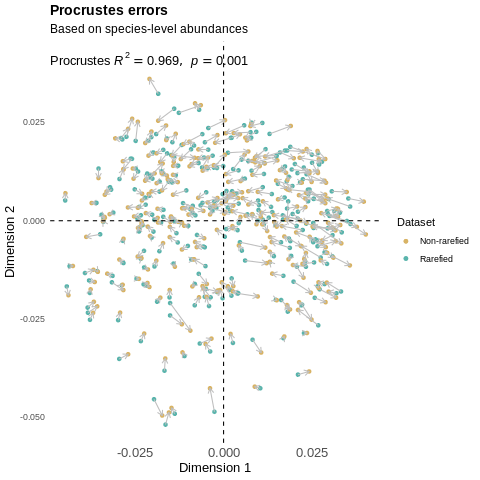

In [17]:
%%R
# Procrustes plot
spp_procrustes_df_to_plot <- data.frame(Y1=spp_clr_pca.vs.spp_clr_12k_pca.procrustes$Yrot[,1],
                                        Y2=spp_clr_pca.vs.spp_clr_12k_pca.procrustes$Yrot[,2],
                                        X1=spp_clr_pca.vs.spp_clr_12k_pca.procrustes$X[,1],
                                        X2=spp_clr_pca.vs.spp_clr_12k_pca.procrustes$X[,2]
                                       )
# procrustes_colors <- c("Non-rarefied"="#d8b365", "Rarefied"="#5ab4ac")
spp_procrustes_annotations <- paste0("list(Procrustes~italic(R^2)== ", 
                                     round(spp_clr_pca.vs.spp_clr_12k_pca.protest$t0,3),
                                     ",~italic(p)== ", 
                                     round(spp_clr_pca.vs.spp_clr_12k_pca.protest$signif,3), ")")

asv16s_spp_procrustes_plot <- ggplot(data=spp_procrustes_df_to_plot) + 
                                geom_point(aes(x=Y1, y=Y2, color="Rarefied")) +
                                geom_point(aes(x=X1, y=X2, color="Non-rarefied")) +
                                geom_segment(aes(x=Y1,y=Y2,xend=X1,yend=X2),
                                             arrow=arrow(length=unit(0.2,"cm")), 
                                             colour="gray") + 
                                geom_hline(yintercept=0, linetype="dashed") + 
                                geom_vline(xintercept=0, linetype="dashed") + 
                                scale_color_manual(values=procrustes_colors) + 
                                annotate("text", label=spp_procrustes_annotations, 
                                         x=-Inf, y=max(spp_procrustes_df_to_plot$Y1+0.005), 
                                         hjust=0, parse=TRUE, size=4.5) +
                                labs(x="Dimension 1", y="Dimension 2", title="Procrustes errors", 
                                     subtitle="Based on species-level abundances", color="Dataset") +
                                theme_minimal() + 
                                theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                      plot.subtitle = element_text(hjust=0,size=12),
                                      axis.text.x=element_text(size=13), 
                                      axis.title=element_text(size=13), 
                                      panel.grid.major = element_blank(), 
                                      panel.grid.minor = element_blank())
asv16s_spp_procrustes_plot

### 2.3 Ordinations based on Centred log-ratio (CLR) transformed genus-level abundances

**CLR transformation of non-rarefied genus-level abundance table**

In [18]:
%%R
# Aggregate abundances to the species level
asv16s_bacteria_genus_table_clr <- otu_table(tax_glom(subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria"), 
                                                "Genus", NArm=FALSE))
print(dim(asv16s_bacteria_genus_table_clr))

[1] 522 307


In [19]:
%%R
# CLR transformation
# -------------------
# Filter rare genera
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*length(sample_names(asv16s_feature_table_ps))/100)
is_above_prev_cutoff <- as.vector(rowSums(asv16s_bacteria_genus_table_clr>0) >= prevalence_cutoff)
asv16s_bacteria_genus_table_clr <- asv16s_bacteria_genus_table_clr[is_above_prev_cutoff,]
print(dim(asv16s_bacteria_genus_table_clr))

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_genus_table_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_genus_table_clr)[sample_has_zero_totals])
    asv16s_bacteria_genus_table_clr <- asv16s_bacteria_genus_table_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(ASV-by-samples) of filtered table: ",
    dim(asv16s_bacteria_genus_table_clr),'\n\n')

# Replace Zeroes (imputation of zeroes) by Bayesian-multiplicative replacement
# returns a sample-by-features table (samples as rows)
cat("\nImputation of zeroes:\n")
asv16s_bacteria_genus_table_clr <- cmultRepl(t(asv16s_bacteria_genus_table_clr),
                                           label=0, method="CZM", output="p-counts")

# Finally, apply CLR-transformation, transposed to return samples as rows
asv16s_bacteria_genus_table_clr <- t(apply(asv16s_bacteria_genus_table_clr, 1, 
                                         function(x){log(x) - mean(log(x))}))
cat("\nDimensions(samples-by-Spp) of filtered table: ",
    dim(asv16s_bacteria_genus_table_clr),'\n')

[1] 147 307

Dimensions(ASV-by-samples) of filtered table:  147 307 


Imputation of zeroes:
No. corrected values:  1575 

Dimensions(samples-by-Spp) of filtered table:  307 147 


**CLR transformation of rarefied genus-level abundance table**

In [20]:
%%R
# Aggregate abundances to the species level
asv16s_bacteria_genus_table_12k_clr <- otu_table(tax_glom(subset_taxa(asv16s_feature_table_12k_ps, 
                                                                    Kingdom=="k__Bacteria"), 
                                                        "Genus", NArm=FALSE))
print(dim(asv16s_bacteria_genus_table_12k_clr))

[1] 468 307


In [21]:
%%R
# CLR transformation
# -------------------
# Filter rare genera
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*length(sample_names(asv16s_feature_table_12k_ps))/100)
is_above_prev_cutoff <- as.vector(rowSums(asv16s_bacteria_genus_table_12k_clr>0) >= prevalence_cutoff)
asv16s_bacteria_genus_table_12k_clr <- asv16s_bacteria_genus_table_12k_clr[is_above_prev_cutoff,]
print(dim(asv16s_bacteria_genus_table_12k_clr))

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_genus_table_12k_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_genus_table_12k_clr)[sample_has_zero_totals])
    asv16s_bacteria_genus_table_12k_clr <- asv16s_bacteria_genus_table_12k_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(ASV-by-samples) of filtered table: ",
    dim(asv16s_bacteria_genus_table_12k_clr),'\n\n')

# Replace Zeroes (imputation of zeroes) by Bayesian-multiplicative replacement
# returns a sample-by-features table (samples as rows)
cat("\nImputation of zeroes:\n")
asv16s_bacteria_genus_table_12k_clr <- cmultRepl(t(asv16s_bacteria_genus_table_12k_clr),
                                                 label=0, method="CZM", output="p-counts")

# Finally, apply CLR-transformation, transposed to return samples as rows
asv16s_bacteria_genus_table_12k_clr <- t(apply(asv16s_bacteria_genus_table_12k_clr, 1, 
                                               function(x){log(x) - mean(log(x))}))
cat("\nDimensions(samples-by-Spp) of filtered table: ",
    dim(asv16s_bacteria_genus_table_12k_clr),'\n')

[1] 134 307

Dimensions(ASV-by-samples) of filtered table:  134 307 


Imputation of zeroes:

Dimensions(samples-by-Spp) of filtered table:  307 134 


**How comparable are PCA ordinations of CLR-transformed non-rarefied and rarefied Spp-level tables?**

In [22]:
%%R
# Principal Component Analysis (PCA)
# with non-rarefied CLR transformed feature table
asv16s_bacteria_genus_table_clr_pca <- prcomp(asv16s_bacteria_genus_table_clr, center=TRUE, scale=FALSE)
# with rarefied CLR trasformed feature table
asv16s_bacteria_genus_table_12k_clr_pca <- prcomp(asv16s_bacteria_genus_table_12k_clr[rownames(asv16s_bacteria_genus_table_clr),], 
                                                center=TRUE, scale=FALSE)

genus_clr_pca.vs.genus_clr_12k_pca.procrustes <- procrustes(X=asv16s_bacteria_genus_table_clr_pca, 
                                                            Y=asv16s_bacteria_genus_table_12k_clr_pca, 
                                                            symmetric=TRUE)
print(genus_clr_pca.vs.genus_clr_12k_pca.procrustes)

genus_clr_pca.vs.genus_clr_12k_pca.protest <- protest(X=asv16s_bacteria_genus_table_clr_pca,
                                                      Y=asv16s_bacteria_genus_table_12k_clr_pca,
                                                      scores="sites", permutations = 999)
print(genus_clr_pca.vs.genus_clr_12k_pca.protest)


Call:
procrustes(X = asv16s_bacteria_genus_table_clr_pca, Y = asv16s_bacteria_genus_table_12k_clr_pca,      symmetric = TRUE) 

Procrustes sum of squares:
0.07414 


Call:
protest(X = asv16s_bacteria_genus_table_clr_pca, Y = asv16s_bacteria_genus_table_12k_clr_pca,      scores = "sites", permutations = 999) 

Procrustes Sum of Squares (m12 squared):        0.07414 
Correlation in a symmetric Procrustes rotation: 0.9622 
Significance:  0.001 

Permutation: free
Number of permutations: 999



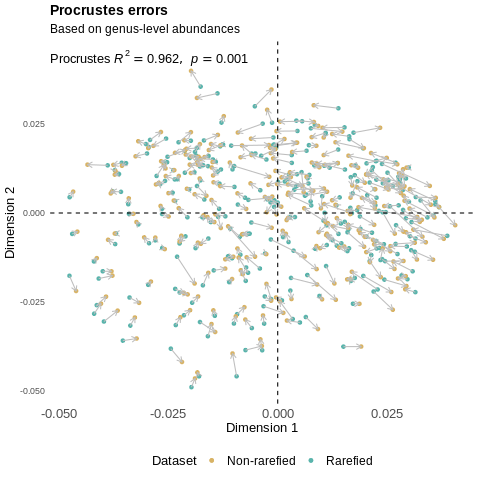

In [23]:
%%R
# Procrustes plot
genus_procrustes_df_to_plot <- data.frame(Y1=genus_clr_pca.vs.genus_clr_12k_pca.procrustes$Yrot[,1],
                                          Y2=genus_clr_pca.vs.genus_clr_12k_pca.procrustes$Yrot[,2],
                                          X1=genus_clr_pca.vs.genus_clr_12k_pca.procrustes$X[,1],
                                          X2=genus_clr_pca.vs.genus_clr_12k_pca.procrustes$X[,2]
                                         )

# procrustes_colors <- c("Non-rarefied"="#d8b365", "Rarefied"="#5ab4ac")
genus_procrustes_annotations <- paste0("list(Procrustes~italic(R^2)== ", 
                                       round(genus_clr_pca.vs.genus_clr_12k_pca.protest$t0,3),
                                       ",~italic(p)== ", 
                                       round(genus_clr_pca.vs.genus_clr_12k_pca.protest$signif,3), ")")

asv16s_genus_procrustes_plot <- ggplot(data=genus_procrustes_df_to_plot) + 
                                geom_point(aes(x=Y1, y=Y2, color="Rarefied")) +
                                geom_point(aes(x=X1, y=X2, color="Non-rarefied")) +
                                geom_segment(aes(x=Y1,y=Y2,xend=X1,yend=X2),
                                             arrow=arrow(length=unit(0.2,"cm")), 
                                             colour="gray") + 
                                geom_hline(yintercept=0, linetype="dashed") + 
                                geom_vline(xintercept=0, linetype="dashed") + 
                                scale_color_manual(values=procrustes_colors) + 
                                annotate("text", label=genus_procrustes_annotations, 
                                         x=-Inf, y=max(genus_procrustes_df_to_plot$Y1+0.005), 
                                         hjust=0, parse=TRUE, size=4.5) +
                                labs(x="Dimension 1", y="Dimension 2", title="Procrustes errors", 
                                     subtitle="Based on genus-level abundances",
                                     color="Dataset") +
                                theme_minimal() + 
                                theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                      plot.subtitle = element_text(hjust=0,size=12),
                                      axis.text.x=element_text(size=13), 
                                      axis.title=element_text(size=13), 
                                      panel.grid.major = element_blank(), 
                                      panel.grid.minor = element_blank(), 
                                      legend.position = "bottom", 
                                      legend.title=element_text(size=13), 
                                      legend.text=element_text(size=12))
procrustres_legend <- cowplot::get_legend(asv16s_genus_procrustes_plot)
asv16s_genus_procrustes_plot

## 2.4. Create panel of Procrustes analysis 

[1] 12.500000  5.555556


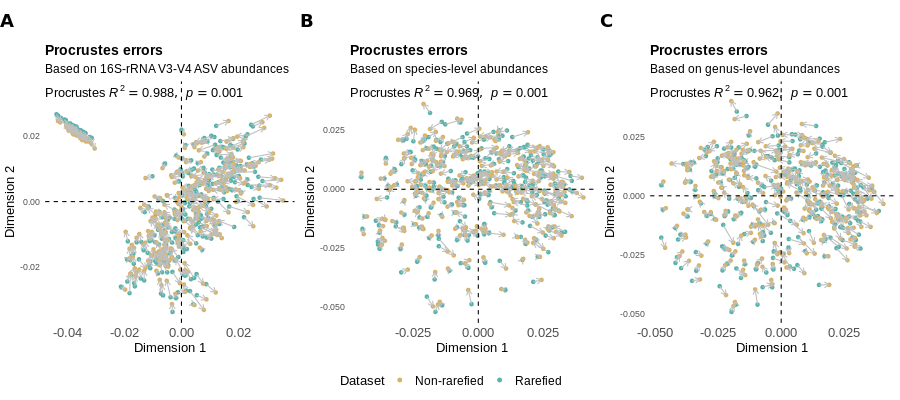

In [24]:
%%R -w 900 -h 400
print(par("din"))
heatmap_layout <- rbind(c(1,1,2,2,3,3),
                        c(4,4,5,5,6,6),
                        c(NA,NA,7,7,NA,NA))

rarefaction_effect_coda_pca <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                                gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                       textGrob("B",just="left", x=unit(0, "npc"), 
                                                                gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                       textGrob("C",just="left", x=unit(0, "npc"), 
                                                                gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                       asv16s_procrustes_plot+theme(legend.position = "none"),
                                                       asv16s_spp_procrustes_plot+theme(legend.position = "none"), 
                                                       asv16s_genus_procrustes_plot+theme(legend.position = "none"), 
                                                       procrustres_legend),
                                            layout_matrix=heatmap_layout, heights=c(0.05,0.4, 0.05))

# Saving panel
rarefaction_effect_coda_pca_file <- "./reports/figures/16S-AS_norarefied-vs-rarefied-clr-ordinations.svg"
ggsave(rarefaction_effect_coda_pca_file, rarefaction_effect_coda_pca, width=12.5, height=5.556)